Knowledge Graphs and How to Complete Them



Knowledge in the world can be represented graphically in the form of entities as nodes and relations between them as edges. Unfortunately, most of the knowledge base graphs are not complete and we need to infer the missing relations. In this colab, we show three classic techniques to complete them.

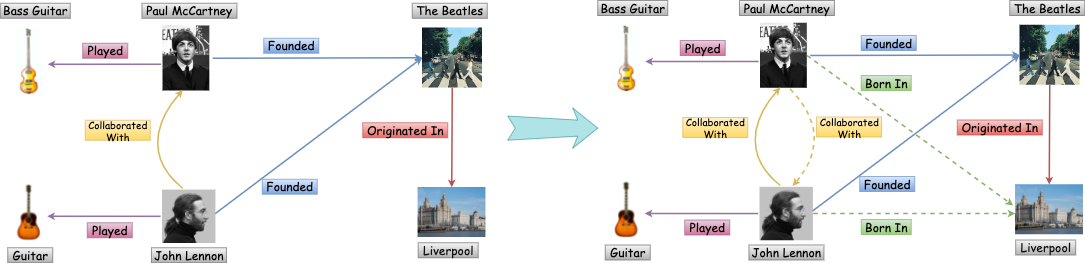

# Required Installations and Imports

In [ ]:
# may take around 5-10 minutes
!pip install ogb
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

import numpy as np
import ogb
import os
import pdb
import random
import torch
import torch_geometric
import tqdm
from ogb.linkproppred import LinkPropPredDataset, PygLinkPropPredDataset
from torch.utils.data import DataLoader, Dataset

1.10.0+cu111
11.1
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


# Dataset Preparation

We focus here on a collaboratively collected knowledge base known by the name of **FB15K-237**, which is derived from Freebase repository. FB15K-237 is a cleaner version of its original counterpart FB15k with inverse relations removed and consists of 14541 entities and 237 relations.

In [ ]:
!wget "https://github.com/kanishkg/fb15k-237/raw/main/fb15k-237-v1.zip"
!tar -xzf fb15k-237-v1.zip

--2021-12-10 04:20:34--  https://github.com/kanishkg/fb15k-237/raw/main/fb15k-237-v1.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kanishkg/fb15k-237/main/fb15k-237-v1.zip [following]
--2021-12-10 04:20:35--  https://raw.githubusercontent.com/kanishkg/fb15k-237/main/fb15k-237-v1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9452681 (9.0M) [application/zip]
Saving to: ‘fb15k-237-v1.zip’

fb15k-237-v1.zip    100%[===================>]   9.01M  --.-KB/s    in 0.1s    

2021-12-10 04:20:36 (80.8 MB/s) - ‘fb15k-237-v1.zip’ saved [9452681/9452681]



In [ ]:
meta_dict = {'eval metric': 'mrr',
             'task type': 'KG_completion',
             'download_name': 'fb15k-237',
             'version': '1',
             'url': 'https://drive.google.com/file/d/1NoebmUcqHheuWCyye6e3zm_rsbM6gvyj/view?usp=sharing',
             'add_inverse_edge': False,
             'has_node_attr': False,
             'has_edge_attr': False,
             'split': 'msr',
             'additional node files': 'None',
             'additional edge files': 'edge_reltype',
             'is hetero': False,
             'binary': False,
             'dir_path': './fb15k-237-v1',
             }
fb_dataset = PygLinkPropPredDataset(name='ogb-fb15k237', meta_dict=meta_dict)

In [ ]:
# split the dataset using the ogb function
split_edge = fb_dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]

In [ ]:
true_edges = torch.load('./fb15k-237-v1/processed/data_processed')

In [ ]:
train_edge

{'edge_feat': None,
 'edge_index': tensor([[ 3818,   819,  9791,  ..., 11737, 12535,  3203],
         [ 8942,  9234,   756,  ...,  4042,  9678, 10433]]),
 'edge_reltype': tensor([[122],
         [230],
         [140],
         ...,
         [198],
         [ 13],
         [ 11]]),
 'node_feat': None,
 'num_nodes': 14541}



# Relation Dataset

We define our dataset class here that generates both positive and negative  triples for training.

In [ ]:
class RelationDataset(Dataset):
  def __init__(self, edges, true_edges, filter=False):
    self.true_edges = true_edges
    self.train_edges = edges
    self.edge_index = edges['edge_index']
    self.edge_reltype = edges['edge_reltype']
    self.num_nodes = edges['num_nodes']
    self.num_rels = 237
    self.rel_dict = {}
    self.true_edge_dict = {}
    self.filter = filter

    # We construct a dictionary that maps edges to relation types
    # We do this to quickly filter out postive edges while sampling negative
    # edges.
    for i in range(self.true_edges['edge_index'].shape[1]):
      h = self.true_edges['edge_index'][0, i]
      t = self.true_edges['edge_index'][1, i]
      r = self.true_edges['edge_reltype'][i, 0]
      if (h,t) not in self.true_edge_dict:
        self.true_edge_dict[(h,t)] = []
      self.true_edge_dict[(h,t)].append(r)

  def __len__(self):
    return self.edge_index.size(1)

  def _sample_negative_edge(self, idx):
    sample = random.uniform(0, 1)
    found = False
    while not found:
      if sample <= 0.4:
        # corrupt the head entity
        h = self.edge_index[0, idx]
        t = torch.randint(0, self.num_nodes, (1,))
        r = self.edge_reltype[idx,:]
      elif 0.4 < sample < 0.8:
        # corrupt the tail entity
        t = self.edge_index[1, idx]
        h = torch.randint(0, self.num_nodes, (1,))
        r = self.edge_reltype[idx,:]
      else:
        # corrupt the relation
        # adding this auxilliary loss is shown to improve performance
        t = self.edge_index[1, idx]
        h = self.edge_index[0, idx]
        r = torch.randint(0, self.num_rels, (1,))
      if not self.filter:
        found = True
      else:
        # check if the edge is a true edge
        if (h, t) not in self.true_edge_dict:
          found = True
        elif r not in self.true_edge_dict[(h, t)]:
          found = True
    data = [torch.tensor([h,t]), r]
    return data

  def __getitem__(self, idx):
    pos_sample = [self.edge_index[:, idx], self.edge_reltype[idx,:]]
    neg_sample = self._sample_negative_edge(idx)
    return pos_sample, neg_sample

In [ ]:
class TestRelationDataset(Dataset):
  def __init__(self, edges, true_edges, filter=False, num_neg=14000, mode='head'):
    self.true_edges = true_edges
    self.edge_index = edges['edge_index']
    self.edge_reltype = edges['edge_reltype']
    self.num_nodes = edges['num_nodes']
    self.num_neg = num_neg
    self.mode = mode
    self.true_edge_dict = {}
    self.filter = filter

    # We construct a dictionary that maps edges to relation types
    # We do this to quickly filter out postive edges while sampling negative
    # edges.
    for i in range(self.true_edges['edge_index'].shape[1]):
      h = self.true_edges['edge_index'][0, i]
      t = self.true_edges['edge_index'][1, i]
      r = self.true_edges['edge_reltype'][i, 0]
      if (h,t) not in self.true_edge_dict:
        self.true_edge_dict[(h,t)] = []
      self.true_edge_dict[(h,t)].append(r)

  def __len__(self):
    return self.edge_index.size(1)

  def _sample_negative_edge(self, idx, mode):
    triples = []
    random_node_idx = list(range(self.num_nodes))
    random.shuffle(random_node_idx)
    for n in random_node_idx:
      r = self.edge_reltype[idx,:]
      if mode == 'head':
        # corrupt tail if in head mode
        t = torch.tensor(n)
        h = self.edge_index[0, idx]
      elif mode == 'tail':
        # corrupt head if in tail mode
        h = torch.tensor(n)
        t = self.edge_index[1, idx]
      ht = torch.tensor([h, t])
      if self.filter:
        # check if edge is present in the knowledge graph
        if (h, t) not in self.true_edge_dict:
          triples.append([ht, r])
        elif r not in self.true_edge_dict[(h, t)]:
            triples.append([ht, r])
      else:
          triples.append([ht, r])
      if len(triples) == self.num_neg:
        break

    return triples

  def __getitem__(self, idx):
    pos_sample = [self.edge_index[:, idx], self.edge_reltype[idx,:]]
    neg_samples = self._sample_negative_edge(idx, mode=self.mode)
    edges = torch.stack([pos_sample[0]] + [ht for ht, _ in neg_samples])
    edge_reltype = torch.stack([pos_sample[1]] + [r for _, r in neg_samples])
    return edges, edge_reltype

# Knowledge Graph Models and their Loss Functions

We define our model classes and there respective loss funtions here

**TransE**


---


TransE is based on the simple idea that the entities and relations can be seen as embeddings in a vector space such that head entity embedding and relation embedding can be added to give tail entity emebdding.

The scoring function for a positive example <h, r, t> is defined as negative of the distance, or mathematically - || h + r - t || so that distance is as low as possible for positive examples. Loss function can then be defined as a max-margin loss which maximizes the distance for negative examples and minimizes for postive examples.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TransE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = torch.nn.Parameter(torch.randn(num_entities, embedding_dim))
        self.relation_embeddings = torch.nn.Parameter(torch.randn(num_relations, embedding_dim))

    def forward(self):
        self.entity_embeddings.data[:-1, :].div_(
            self.entity_embeddings.data[:-1, :].norm(p=2, dim=1, keepdim=True))
        return self.entity_embeddings, self.relation_embeddings

TransE Loss

In [ ]:
def TransE_loss(pos_edges, neg_edges, pos_reltype, neg_reltype, entity_embeddings,
                relation_embeddings):
  # Select embeddings for both positive and negative samples
  pos_head_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 0])
  pos_tail_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 1])
  neg_head_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 0])
  neg_tail_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 1])
  pos_relation_embeds = torch.index_select(relation_embeddings, 0, pos_reltype.squeeze())
  neg_relation_embeds = torch.index_select(relation_embeddings, 0, neg_reltype.squeeze())

  # Calculate the distance score
  d_pos = torch.norm(pos_head_embeds + pos_relation_embeds - pos_tail_embeds, p=1, dim=1)
  d_neg = torch.norm(neg_head_embeds + neg_relation_embeds - neg_tail_embeds, p=1, dim=1)
  ones = torch.ones(d_pos.size(0))

  # margin loss - we want to increase d_neg and decrease d_pos
  margin_loss = torch.nn.MarginRankingLoss(margin=1.)
  loss = margin_loss(d_neg, d_pos, ones)

  return loss

**ComplEx**


---
ComplEx model proposes that we represent the entity and triple embeddings in a complex vector space. In ComplEx, we learn embeddings by treating the problem as a binary classification problem where the goal is to classify each triple as either positive (0) or corrupt (1).  

For a triple <h, r, t>, the similarity function takes the dot product of h, r and the complex conjugate of t and returns the real value of the product. Intuitively, this measures the similarity (specifically cosine similarity) between <h, r> and the complex conjugate of t.




In [ ]:
class ComplEx(nn.Module):
  def __init__(self, num_entities, num_relations, embedding_dim):
    super(ComplEx, self).__init__()
    self.entity_embeddings = torch.nn.Parameter(torch.randn(num_entities, embedding_dim))
    self.relation_embeddings = torch.nn.Parameter(torch.randn(num_relations, embedding_dim))

  def forward(self):
    # return the embeddings as it is but we can regularize here by normalizing them
    return self.entity_embeddings, self.relation_embeddings

ComplEx Loss

In [ ]:
def ComplEx_loss(pos_edges, neg_edges, pos_reltype, neg_reltype,
                 entity_embeddings, relation_embeddings, reg=1e-3):
  # Select embeddings for both positive and negative samples
  pos_head_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 0])
  pos_tail_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 1])
  neg_head_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 0])
  neg_tail_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 1])
  pos_relation_embeds = torch.index_select(relation_embeddings, 0, pos_reltype.squeeze())
  neg_relation_embeds = torch.index_select(relation_embeddings, 0, neg_reltype.squeeze())

  # Get real and imaginary parts
  pos_re_relation, pos_im_relation = torch.chunk(pos_relation_embeds, 2, dim=1)
  neg_re_relation, neg_im_relation = torch.chunk(neg_relation_embeds, 2, dim=1)
  pos_re_head, pos_im_head = torch.chunk(pos_head_embeds, 2, dim=1)
  pos_re_tail, pos_im_tail = torch.chunk(pos_tail_embeds, 2, dim=1)
  neg_re_head, neg_im_head = torch.chunk(neg_head_embeds, 2, dim=1)
  neg_re_tail, neg_im_tail = torch.chunk(neg_tail_embeds, 2, dim=1)

  # Compute pos score
  pos_re_score = pos_re_head * pos_re_relation - pos_im_head * pos_im_relation
  pos_im_score = pos_re_head * pos_im_relation + pos_im_head * pos_re_relation
  pos_score = pos_re_score * pos_re_tail + pos_im_score * pos_im_tail
  pos_loss = -F.logsigmoid(pos_score.sum(1))


  # Compute neg score
  neg_re_score = neg_re_head * neg_re_relation - neg_im_head * neg_im_relation
  neg_im_score = neg_re_head * neg_im_relation + neg_im_head * neg_re_relation
  neg_score = neg_re_score * neg_re_tail + neg_im_score * neg_im_tail
  neg_loss = -F.logsigmoid(-neg_score.sum(1))

  loss = pos_loss + neg_loss
  reg_loss = reg * (
      pos_re_head.norm(p=2, dim=1)**2 + pos_im_head.norm(p=2, dim=1)**2 +
      pos_re_tail.norm(p=2, dim=1)**2 + pos_im_tail.norm(p=2, dim=1)**2 +
      neg_re_head.norm(p=2, dim=1)**2 + neg_im_head.norm(p=2, dim=1)**2 +
      neg_re_tail.norm(p=2, dim=1)**2 + neg_im_tail.norm(p=2, dim=1)**2 +
      pos_re_relation.norm(p=2, dim=1)**2 + pos_im_relation.norm(p=2, dim=1)**2 +
      neg_re_relation.norm(p=2, dim=1)**2 + neg_im_relation.norm(p=2, dim=1)**2)
  loss += reg_loss
  return loss.mean()

**RotatE**

---

RotatE model can be seen as equivalent to TransE but in complex space. In this model, relations give angular rotation to the head entity embedding by an angle so as to make it closer to the tail entity embedding.

The scoring function can be defined as - || h 𝗈 r - t || just like TransE but here we use rotation operator 'o' instead of simple addition.


In [ ]:
class RotatE(nn.Module):
  def __init__(self, num_entities, num_relations, embedding_dim):
    super(RotatE, self).__init__()
    # entity embeddings has equal real and imaginary parts, so we double the dimension size
    self.entity_embeddings = torch.nn.Parameter(torch.randn(num_entities, 2*embedding_dim))
    self.relation_embeddings = torch.nn.Parameter(torch.randn(num_relations, embedding_dim))

  def forward(self):
    # return the embeddings as it is but we can regularize here by normalizing them
    return self.entity_embeddings, self.relation_embeddings

RotatE Loss

In [ ]:
def RotatE_loss(pos_edges, neg_edges, pos_reltype, neg_reltype, entity_embeddings, relation_embeddings,
                gamma=5.0, epsilon=2.0):
  # Select embeddings for both positive and negative samples
  pos_head_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 0])
  pos_tail_embeds = torch.index_select(entity_embeddings, 0, pos_edges[:, 1])
  neg_head_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 0])
  neg_tail_embeds = torch.index_select(entity_embeddings, 0, neg_edges[:, 1])
  pos_relation_embeds = torch.index_select(relation_embeddings, 0, pos_reltype.squeeze())
  neg_relation_embeds = torch.index_select(relation_embeddings, 0, neg_reltype.squeeze())

  # Dissect the embedding in equal chunks to get real and imaginary parts
  pos_re_head, pos_im_head = torch.chunk(pos_head_embeds, 2, dim=1)
  pos_re_tail, pos_im_tail = torch.chunk(pos_tail_embeds, 2, dim=1)
  neg_re_head, neg_im_head = torch.chunk(neg_head_embeds, 2, dim=1)
  neg_re_tail, neg_im_tail = torch.chunk(neg_tail_embeds, 2, dim=1)

  # Make phases of relations uniformly distributed in [-pi, pi]
  embedding_range = 2 * (gamma + epsilon) / pos_head_embeds.size(-1)
  pos_phase_relation = pos_relation_embeds/(embedding_range/np.pi)

  pos_re_relation = torch.cos(pos_phase_relation)
  pos_im_relation = torch.sin(pos_phase_relation)

  neg_phase_relation = neg_relation_embeds/(embedding_range/np.pi)
  neg_re_relation = torch.cos(neg_phase_relation)
  neg_im_relation = torch.sin(neg_phase_relation)


  # Compute pos score
  pos_re_score = pos_re_head * pos_re_relation - pos_im_head * pos_im_relation
  pos_im_score = pos_re_head * pos_im_relation + pos_im_head * pos_re_relation
  pos_re_score = pos_re_score - pos_re_tail
  pos_im_score = pos_im_score - pos_im_tail
  # Stack and take squared norm of real and imaginary parts
  pos_score = torch.stack([pos_re_score, pos_im_score], dim = 0)
  pos_score = pos_score.norm(dim = 0)
  # Log sigmoid of margin loss
  pos_score = gamma - pos_score.sum(dim = 1)
  pos_score = - F.logsigmoid(pos_score)

  # Compute neg score
  neg_re_score = neg_re_head * neg_re_relation - neg_im_head *neg_im_relation
  neg_im_score = neg_re_head * neg_im_relation + neg_im_head * neg_re_relation
  neg_re_score = neg_re_score - neg_re_tail
  neg_im_score = neg_im_score - neg_im_tail
  # Stack and take squared norm of real and imaginary parts
  neg_score = torch.stack([neg_re_score, neg_im_score], dim = 0)
  neg_score = neg_score.norm(dim = 0)
  # Log sigmoid of margin loss
  neg_score = gamma - neg_score.sum(dim = 1)
  neg_score = - F.logsigmoid(-neg_score)

  loss = (pos_score + neg_score)/2

  return loss.mean()

# Metrics and Model Evaluation

Helper routine to get the metric values given the predicted scores for a bunch of negative samples along with a positive sample that is always the first element at index 0. We currently have functionality to report these metrics:

1) Hits@1

2) Hits@3

3) Hits@10

4) Mean Rank

5) Mean Reciprocal Rank

In [ ]:
def eval_metrics(y_pred):
  argsort = torch.argsort(y_pred, dim = 1, descending = False)
  # not using argsort to do the rankings to avoid bias when the scores are equal
  ranking_list = torch.nonzero(argsort == 0, as_tuple=False)
  ranking_list = ranking_list[:, 1] + 1
  hits1_list = (ranking_list <= 1).to(torch.float)
  hits3_list = (ranking_list <= 3).to(torch.float)
  hits10_list = (ranking_list <= 10).to(torch.float)
  mr_list = ranking_list.to(torch.float)
  mrr_list = 1./ranking_list.to(torch.float)
  return hits1_list.mean(), hits3_list.mean(), hits10_list.mean(), mr_list.mean(), mrr_list.mean()

Evaluation routine which given a head and relation, it ranks the original positive entity along with a bunch of negative entities on the basis of scoring criteria per model and calculates above metrics

In [ ]:
def eval(entity_embeddings, relation_embeddings, dataloader, kg_model, iters=None, gamma = 5.0, epsilon = 2.0):

  hits1_list = []
  hits3_list = []
  hits10_list = []
  mr_list = []
  mrr_list = []
  data_iterator = iter(dataloader)
  if iters is None:
    iters = len(dataloader)
  for _ in tqdm.trange(iters, desc="Evaluating"):
    batch = next(data_iterator)
    edges, edge_reltype = batch
    b, num_samples, _= edges.size()
    edges = edges.view(b*num_samples, -1)
    edge_reltype = edge_reltype.view(b*num_samples, -1)

    head_embeds = torch.index_select(entity_embeddings, 0, edges[:, 0])
    relation_embeds = torch.index_select(relation_embeddings, 0, edge_reltype.squeeze())
    tail_embeds = torch.index_select(entity_embeddings, 0, edges[:, 1])

    if kg_model == "TransE":
      scores = torch.norm(head_embeds + relation_embeds - tail_embeds, p=1, dim=1)
    elif kg_model == "ComplEx":
      # Get real and imaginary parts
      re_relation, im_relation = torch.chunk(relation_embeds, 2, dim=1)
      re_head, im_head = torch.chunk(head_embeds, 2, dim=1)
      re_tail, im_tail = torch.chunk(tail_embeds, 2, dim=1)

      # Compute scores
      re_score = re_head * re_relation - im_head * im_relation
      im_score = re_head * im_relation + im_head * re_relation
      scores = (re_score * re_tail + im_score * im_tail)
      # Negate as we want to rank scores in ascending order, lower the better
      scores = - scores.sum(dim=1)
    elif kg_model == "RotatE":
      # Get real and imaginary parts
      re_head, im_head = torch.chunk(head_embeds, 2, dim=1)
      re_tail, im_tail = torch.chunk(tail_embeds, 2, dim=1)

      # Make phases of relations uniformly distributed in [-pi, pi]
      embedding_range = 2 * (gamma + epsilon) / head_embeds.size(-1)
      phase_relation = relation_embeds/(embedding_range/np.pi)
      re_relation = torch.cos(phase_relation)
      im_relation = torch.sin(phase_relation)

      # Compute scores
      re_score = re_head * re_relation - im_head * im_relation
      im_score = re_head * im_relation + im_head * re_relation
      re_score = re_score - re_tail
      im_score = im_score - im_tail
      scores = torch.stack([re_score, im_score], dim = 0)
      scores = scores.norm(dim = 0)
      scores = scores.sum(dim = 1)
    else:
      raise ValueError(f'Unsupported model {kg_model}')

    scores = scores.view(b, num_samples)

    hits1, hits3, hits10, mr, mrr = eval_metrics(scores)
    hits1_list.append(hits1.item())
    hits3_list.append(hits3.item())
    hits10_list.append(hits10.item())
    mr_list.append(mr.item())
    mrr_list.append(mrr.item())

  hits1 = sum(hits1_list)/len(hits1_list)
  hits3 = sum(hits3_list)/len(hits1_list)
  hits10 = sum(hits10_list)/len(hits1_list)
  mr = sum(mr_list)/len(hits1_list)
  mrr = sum(mrr_list)/len(hits1_list)

  return hits1, hits3, hits10, mr, mrr

# Training

In [ ]:
#@title Choose your model and training parameters
kg_model = "RotatE" #@param ["TransE", "ComplEx", "RotatE"]
epochs = 100 #@param {type:"slider", min:10, max:500, step:10}
batch_size = 128 #@param {type:"number"}
learning_rate = 1e-3 #@param {type:"number"}

num_entities = 14541
num_relations = 237

if kg_model == "TransE":
    model = TransE(num_entities, num_relations, 100)
    model_loss = TransE_loss
elif kg_model == "ComplEx":
    model = ComplEx(num_entities, num_relations, 100)
    model_loss = ComplEx_loss
elif kg_model == "RotatE":
    model = RotatE(num_entities, num_relations, 50)
    model_loss = RotatE_loss
else:
    raise ValueError('Unsupported model %s' % kg_model)

NameError: ignored

In [ ]:
num_workers = os.cpu_count()

train_dataset = RelationDataset(train_edge, true_edges, filter=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataset = RelationDataset(valid_edge, true_edges, filter=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

val_eval_dataset = TestRelationDataset(valid_edge, true_edges, filter=True, num_neg=100)
val_eval_dataloader = DataLoader(val_eval_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataset = TestRelationDataset(test_edge, true_edges, filter=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f'Train dataset size {len(train_dataset)}')
print(f'Val dataset size {len(val_dataset)}')
print(f'Test dataset size {len(test_dataset)}')

Train dataset size 272115
Val dataset size 17535
Test dataset size 20466


In [ ]:
# use adam optimizer for training
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for e in range(epochs):
  losses = []
  # check evaluation metrics every 10th epoch
  if e%10 == 0:
    model.eval()
    h1, h3, h10, mr, mrr = eval(model.entity_embeddings, model.relation_embeddings, val_eval_dataloader, kg_model, iters=10)
    print(f"hits@1:{h1} hits@3:{h3} hits@10:{h10} mr:{mr} mrr:{mrr}")
  model.train()
  for step, batch in enumerate(tqdm.tqdm(train_dataloader, desc="Training")):
    # generate positive as well as negative samples for training
    pos_sample, neg_sample = batch
    # do a forward pass through the model
    entity_embeddings_pass, relation_embeddings_pass = model()

    optimizer.zero_grad()

    # compute the loss as per your model scoring criteria
    loss = model_loss(pos_sample[0], neg_sample[0], pos_sample[1], neg_sample[1],
                      entity_embeddings_pass, relation_embeddings_pass)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

  val_losses = []
  model.eval()
  entity_embeddings_pass, relation_embeddings_pass = model()
  # compute validation loss on unseen samples we didn't train on
  for step, batch in enumerate(tqdm.tqdm(val_dataloader, desc="Validating")):
    pos_sample, neg_sample = batch
    loss = model_loss(pos_sample[0], neg_sample[0], pos_sample[1], neg_sample[1],
                      entity_embeddings_pass, relation_embeddings_pass)
    val_losses.append(loss.item())

  print(f"epoch: {e + 1} loss: {sum(losses)/len(losses)} val_loss: {sum(val_losses)/len(val_losses)}")

Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


hits@1:0.56484375 hits@3:0.73359375 hits@10:0.89296875 mr:4.8546875 mrr:0.6753929495811463


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.78it/s]


epoch: 1 loss: 0.06732275679896771 val_loss: 0.13547529454213858


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.97it/s]


epoch: 2 loss: 0.06815271085497913 val_loss: 0.13382548137302816


Validating: 100%|██████████| 137/137 [00:01<00:00, 128.35it/s]


epoch: 3 loss: 0.06740859360105568 val_loss: 0.1322372573679381


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.33it/s]


epoch: 4 loss: 0.06717213636276471 val_loss: 0.1303546155129906


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.59it/s]


epoch: 5 loss: 0.06773391526686562 val_loss: 0.12991780880158835


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.61it/s]


epoch: 6 loss: 0.06737704628680746 val_loss: 0.1364327196276536


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.09it/s]


epoch: 7 loss: 0.0678763163091154 val_loss: 0.14179258385713953


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.08it/s]


epoch: 8 loss: 0.06769377247606485 val_loss: 0.13302352904838366


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.11it/s]


epoch: 9 loss: 0.06660719561414234 val_loss: 0.13577832140191629


Validating: 100%|██████████| 137/137 [00:01<00:00, 126.00it/s]

epoch: 10 loss: 0.06728317480804162 val_loss: 0.1335805355414857



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


hits@1:0.578125 hits@3:0.76015625 hits@10:0.8984375 mr:4.7578125 mrr:0.689726036787033


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.37it/s]


epoch: 11 loss: 0.06523290240430989 val_loss: 0.13541864728840597


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.59it/s]


epoch: 12 loss: 0.06717195082543487 val_loss: 0.13880689714076747


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.44it/s]


epoch: 13 loss: 0.06490396440505757 val_loss: 0.13597170589831623


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.35it/s]


epoch: 14 loss: 0.0661570481948996 val_loss: 0.13254227200998878


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.65it/s]


epoch: 15 loss: 0.06525033334601296 val_loss: 0.13767806391646392


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.06it/s]


epoch: 16 loss: 0.06459006619125408 val_loss: 0.13286802161784067


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.86it/s]


epoch: 17 loss: 0.06419271275730538 val_loss: 0.13324520829385214


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.16it/s]


epoch: 18 loss: 0.0642747001605054 val_loss: 0.1345919772003689


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.23it/s]


epoch: 19 loss: 0.06488736244733335 val_loss: 0.13554537486638465


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.83it/s]

epoch: 20 loss: 0.06448578650328074 val_loss: 0.12409671216550534



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


hits@1:0.60859375 hits@3:0.77265625 hits@10:0.90859375 mr:4.3953125 mrr:0.7107583105564117


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.41it/s]


epoch: 21 loss: 0.0640021462084573 val_loss: 0.12833160841769545


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.20it/s]


epoch: 22 loss: 0.06513504317049586 val_loss: 0.12338607274267795


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.49it/s]


epoch: 23 loss: 0.06300868060324176 val_loss: 0.1283877404936909


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.84it/s]


epoch: 24 loss: 0.06405497268052564 val_loss: 0.1365479872065739


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.46it/s]


epoch: 25 loss: 0.06385552423707405 val_loss: 0.12870054849742973


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.39it/s]


epoch: 26 loss: 0.06388593864603527 val_loss: 0.12837177460646107


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.27it/s]


epoch: 27 loss: 0.06203029844787249 val_loss: 0.12539993998778126


Validating: 100%|██████████| 137/137 [00:01<00:00, 117.69it/s]


epoch: 28 loss: 0.06268597584522678 val_loss: 0.13803553477908573


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.69it/s]


epoch: 29 loss: 0.062352961754585816 val_loss: 0.13201842625645827


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.22it/s]

epoch: 30 loss: 0.06311829821824298 val_loss: 0.13281022632209055



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


hits@1:0.61953125 hits@3:0.771875 hits@10:0.91796875 mr:3.64609375 mrr:0.7171742439270019


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.76it/s]


epoch: 31 loss: 0.06339187417372094 val_loss: 0.13781524531162567


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.02it/s]


epoch: 32 loss: 0.061302112194649025 val_loss: 0.1268102727340956


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.57it/s]


epoch: 33 loss: 0.0635229965298667 val_loss: 0.12343359069667593


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.83it/s]


epoch: 34 loss: 0.06257683930608425 val_loss: 0.12605412641580957


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.68it/s]


epoch: 35 loss: 0.061347077946727946 val_loss: 0.12660584283353638


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.56it/s]


epoch: 36 loss: 0.0629254228077121 val_loss: 0.12309780281825658


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.96it/s]


epoch: 37 loss: 0.06209421394391096 val_loss: 0.12583666659184617


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.54it/s]


epoch: 38 loss: 0.06254832747261814 val_loss: 0.12766732318993032


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.32it/s]


epoch: 39 loss: 0.061947127022655195 val_loss: 0.1323207634208846


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.97it/s]

epoch: 40 loss: 0.0628026095188292 val_loss: 0.12902316287921292



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


hits@1:0.59296875 hits@3:0.75390625 hits@10:0.90546875 mr:4.50234375 mrr:0.6972998261451722


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.06it/s]


epoch: 41 loss: 0.06344252089187433 val_loss: 0.13427488418826222


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.85it/s]


epoch: 42 loss: 0.06262283212910928 val_loss: 0.12375084560935515


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.90it/s]


epoch: 43 loss: 0.0613630084024772 val_loss: 0.1337016699087881


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.17it/s]


epoch: 44 loss: 0.061028287838005506 val_loss: 0.12985379420166468


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.22it/s]


epoch: 45 loss: 0.06305165867113552 val_loss: 0.1265566684033749


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.48it/s]


epoch: 46 loss: 0.062352607112556614 val_loss: 0.12791437421836993


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.56it/s]


epoch: 47 loss: 0.06261982849990969 val_loss: 0.13100031175970162


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.65it/s]


epoch: 48 loss: 0.061175996349618074 val_loss: 0.12804586249981484


Validating: 100%|██████████| 137/137 [00:01<00:00, 126.99it/s]


epoch: 49 loss: 0.061367327538393406 val_loss: 0.13037993601203834


Validating: 100%|██████████| 137/137 [00:01<00:00, 121.85it/s]

epoch: 50 loss: 0.06127775424034777 val_loss: 0.13209140703190853



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


hits@1:0.5703125 hits@3:0.7515625 hits@10:0.90546875 mr:4.7765625 mrr:0.6823648869991302


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.60it/s]


epoch: 51 loss: 0.06139210858036215 val_loss: 0.12774795195917144


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.86it/s]


epoch: 52 loss: 0.06162340679010578 val_loss: 0.125828335156841


Validating: 100%|██████████| 137/137 [00:01<00:00, 118.10it/s]


epoch: 53 loss: 0.06079078029914779 val_loss: 0.1271802927673298


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.59it/s]


epoch: 54 loss: 0.06068019395096618 val_loss: 0.12673136091580356


Validating: 100%|██████████| 137/137 [00:01<00:00, 119.51it/s]


epoch: 55 loss: 0.0616458673126512 val_loss: 0.1293240441893139


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.94it/s]


epoch: 56 loss: 0.06100849273175646 val_loss: 0.12268437124299307


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.97it/s]


epoch: 57 loss: 0.06108302475318579 val_loss: 0.126083584053673


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.55it/s]


epoch: 58 loss: 0.06044336501859402 val_loss: 0.12630175891583853


Validating: 100%|██████████| 137/137 [00:01<00:00, 128.03it/s]


epoch: 59 loss: 0.061611378688088365 val_loss: 0.12025651933938047


Validating: 100%|██████████| 137/137 [00:01<00:00, 126.40it/s]

epoch: 60 loss: 0.05981244577527719 val_loss: 0.12606344170814013



Evaluating: 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


hits@1:0.57578125 hits@3:0.76640625 hits@10:0.91171875 mr:4.30390625 mrr:0.690211683511734


Validating: 100%|██████████| 137/137 [00:01<00:00, 128.93it/s]


epoch: 61 loss: 0.06108698402711051 val_loss: 0.12236687666090736


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.65it/s]


epoch: 62 loss: 0.05987752282594244 val_loss: 0.12562453670658336


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.77it/s]


epoch: 63 loss: 0.06131961420949405 val_loss: 0.122855026410879


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.28it/s]


epoch: 64 loss: 0.06105735360076152 val_loss: 0.12874791075060837


Validating: 100%|██████████| 137/137 [00:01<00:00, 127.53it/s]


epoch: 65 loss: 0.060548695110955106 val_loss: 0.12329026023401832


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.42it/s]


epoch: 66 loss: 0.05904878550476324 val_loss: 0.13020281276128587


Validating: 100%|██████████| 137/137 [00:01<00:00, 126.08it/s]


epoch: 67 loss: 0.06044156458281394 val_loss: 0.12808186620691397


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.76it/s]


epoch: 68 loss: 0.060264150744351375 val_loss: 0.12489436371048002


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.32it/s]


epoch: 69 loss: 0.060929585388412144 val_loss: 0.11950301580185438


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.53it/s]

epoch: 70 loss: 0.059773669778768 val_loss: 0.12354948328141749



Evaluating: 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]


hits@1:0.60625 hits@3:0.7703125 hits@10:0.9015625 mr:4.284375 mrr:0.7102800905704498


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.60it/s]


epoch: 71 loss: 0.05952392439318511 val_loss: 0.12237205535826022


Validating: 100%|██████████| 137/137 [00:01<00:00, 117.85it/s]


epoch: 72 loss: 0.06008168713996574 val_loss: 0.12194965268573622


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.03it/s]


epoch: 73 loss: 0.06006213090788163 val_loss: 0.1242610168283003


Validating: 100%|██████████| 137/137 [00:01<00:00, 120.71it/s]


epoch: 74 loss: 0.05935092703881739 val_loss: 0.12941154478675257


Validating: 100%|██████████| 137/137 [00:01<00:00, 124.92it/s]


epoch: 75 loss: 0.059488600086655574 val_loss: 0.12631836446532368


Validating: 100%|██████████| 137/137 [00:01<00:00, 122.50it/s]


epoch: 76 loss: 0.05968007248907805 val_loss: 0.12246432356590772


Validating: 100%|██████████| 137/137 [00:01<00:00, 125.01it/s]


epoch: 77 loss: 0.05928861279380512 val_loss: 0.12420323306191576


Validating: 100%|██████████| 137/137 [00:01<00:00, 127.23it/s]


epoch: 78 loss: 0.05964645768252051 val_loss: 0.12497306680374771


Validating: 100%|██████████| 137/137 [00:01<00:00, 123.61it/s]


epoch: 79 loss: 0.058969546395055215 val_loss: 0.1220502016970711


Training:  77%|███████▋  | 1641/2126 [01:25<00:24, 19.63it/s]

Now let's test if our model actually learned something!

In [ ]:
#@title Test your trained model
iterations = 1000 #@param {type:"slider", min:100, max:2000, step:100}
mode = "head" #@param ["head", "tail"]

model.eval()
test_dataset = TestRelationDataset(test_edge, true_edges, filter=True, mode=mode)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

eval(model.entity_embeddings, model.relation_embeddings, test_dataloader, kg_model, iters=iterations)

Evaluating: 100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


(0.119, 0.215, 0.369, 193.727, 0.20023192654850572)

For reference, we tabulate the results we obtained for different models here:

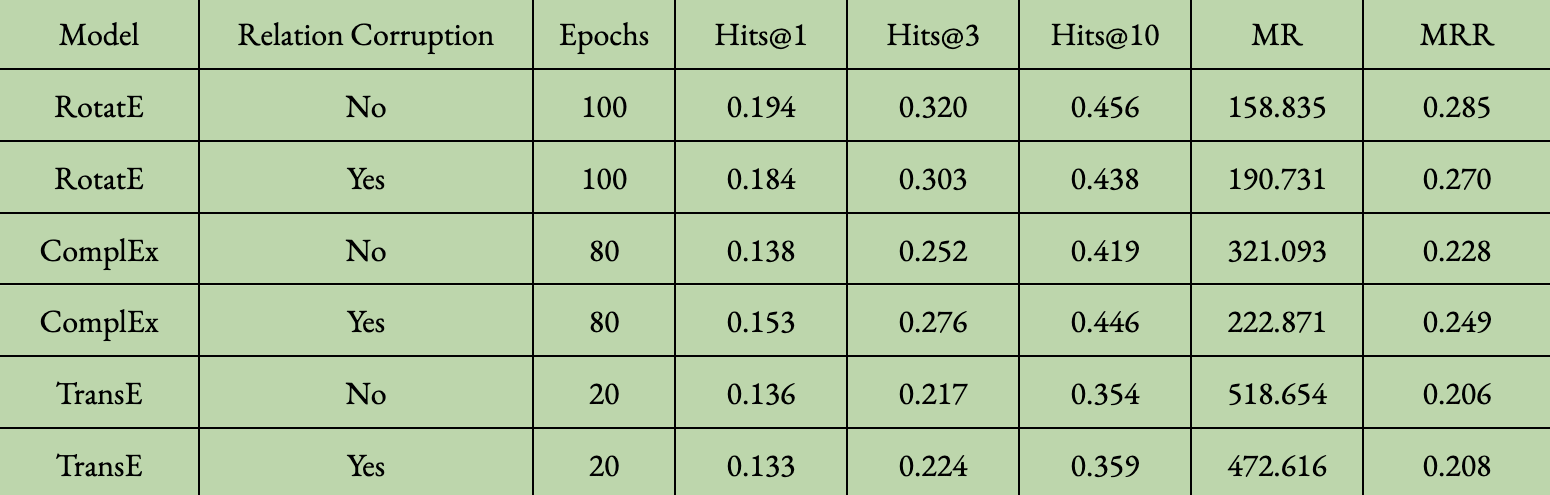